In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
from biodata.delimited import DelimitedReader, DelimitedWriter
import pybedtools
import itertools
from biodatatools.utils.common import json_load
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
import sys
from pathlib import Path
from Bio import SeqIO
import subprocess
from scipy.stats import fisher_exact

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"

In [5]:
sys.path.append(f"{PROJECT_DIR_s}procapnet/2_train_models/")
import data_loading
sys.path.append(f"{PROJECT_DIR_s}procapnet/5_modisco/")
from modiscolite_utils import load_modisco_results

# Motif prediction

In [9]:
s = "HEK293T"
factor = "ZNF143"
ks = ["+", "-"]
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]
ts = ["minTSS", "maxTSS"]
labels = ["Up", "Down"]
motifs = ["THAP11", "ZNF143", "THAP11-ZNF143"]

## Get motif patterns

In [10]:
modisco_results = load_modisco_results(f"{PROJECT_DIR_o}procapnet/modisco_out/HCT116/strand_merged_umap/merged/counts_modisco_results.hd5")
pattern = modisco_results["pos_patterns"]["pattern_9"]
pwm = pattern["sequence"][:]
pwm_ic = pwm * compute_per_position_ic(pwm)[:, None]
start, end = trim_motif_by_thresh(pwm_ic)
pwm_trim = pwm[start:end]

In [11]:
# Get individual motif patterns (THAP11, ZNF143) from JASPAR "data_preprocessing/2.Other_resource.ipynb"
# Get PWM of THAP11-ZNF143 composite motif from tfmodisco

motif_file = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_{factor}.txt"
with open(motif_file, "r") as fr:
	lines = fr.readlines()
	
new_lines = ['MOTIF ProCapNet THAP11-ZNF143\n',
			 F'letter-probability matrix: alength= 4 w= {len(pwm_trim)} \n',
			]
for row in pwm_trim:
	row[-1] = 1-np.sum(row[:-1])
	vs = "\t".join([f"{v:.6f}" for v in row])
	new_lines.append(f" {vs}\n")
new_lines.append('\n')
lines.extend(new_lines)

with open(motif_file, "w") as fw:
	for line in lines:
		fw.write(line)

In [12]:
def read_meme(filename):
    pwms = {}
    motif_name = None
    pwm_lines = []

    def save_pwm(name, lines):
        if lines:
            # only keep lines with exactly 4 floats
            clean_lines = [line for line in lines if len(line) == 4]
            if clean_lines:
                pwms[name] = np.array(clean_lines, dtype=float)

    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line.startswith("MOTIF"):
                # save previous motif
                save_pwm(motif_name, pwm_lines)
                motif_name = line.split()[1]
                pwm_lines = []
            elif line.startswith("letter-probability matrix"):
                pwm_lines = []
            else:
                parts = line.split()
                # only numeric lines with 4 values
                if len(parts) == 4:
                    try:
                        pwm_lines.append([float(x) for x in parts])
                    except ValueError:
                        pass
        # save last motif
        save_pwm(motif_name, pwm_lines)

    return pwms

In [22]:
%matplotlib inline

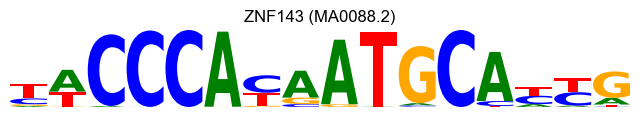

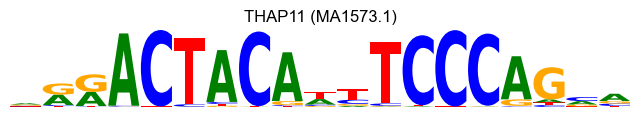

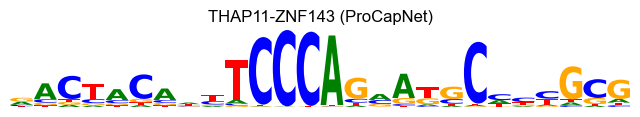

In [16]:
# The motif pattern detected by ProCapNet is composed of THAP11 (left) and ZNF143 (right) motifs from JASPAR
# In Dong et al, de novo motif discovery (Fig.1c) using ZNF143 ChIP-seq: the most abundant pattern looks like THAP11 from JASPAR and the second one looks more like ZNF143 from JASPAR; the average pattern (Fig.1d) looks like the pattern identified by ProCapNet 

pwms = read_meme(motif_file)
titles = ["ZNF143 (MA0088.2)", "THAP11 (MA1573.1)", "THAP11-ZNF143 (ProCapNet)"]
for motif in pwms:
	fig, ax = plt.subplots(figsize=(8,1))
	n = list(pwms).index(motif)
	pwm_ic = pwms[motif] * utils.compute_per_position_ic(pwms[motif])[:, None]
	utils.plot_motif_on_ax(pwm_ic, ax, titles[n])	

## Get sequences

In [17]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [18]:
def get_sequence_for_prediction(inputfiles, fdict, outputfile):
	with DelimitedWriter(outputfile) as dw:
		for inputfile in inputfiles:
			with DelimitedReader(inputfile) as dr:
				for cols in dr:
					chrom, start, end = cols[:3]
					dw.write([">" + "_".join([chrom, start, end])])
					seq = fdict[chrom][int(start):int(end)].seq.upper()
					dw.write([seq])

In [19]:
inputfiles = [f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed" for g in gs]
outputfile = f"{PROJECT_DIR_o}FIMO/{s}_seqs.fa"
get_sequence_for_prediction(inputfiles, fdict, outputfile)

## Run FIMO

In [20]:
def get_motifs(motif_file, seq_file, outputfile):
	commands = [f"{PROJECT_DIR_s}meme-5.5.7/src/fimo", 
				 "--skip-matched-sequence",
				 "--verbosity 1",
				 motif_file, 
				 seq_file,
				 ">", outputfile
				 ]
	subprocess.run(" ".join(commands), shell=True)

In [21]:
# By default the program reports all motif occurrences with a p-value less than 1e-4. 

seq_file = f"{PROJECT_DIR_o}FIMO/{s}_seqs.fa"
outputfile = f"{PROJECT_DIR_o}FIMO/{s}_predictions.txt"
get_motifs(motif_file, seq_file, outputfile)

In [12]:
# https://meme-suite.org/meme/doc/fimo-output-format.html#tsv_results
# start: 1-based, included
# stop: 1-based, included

inputfile = f"{PROJECT_DIR_o}FIMO/{s}_predictions.txt"
df_fimo = pd.read_table(inputfile)
df_fimo.head(2)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MA0088.2,ZNF143,chr1_916612_917113,66,81,+,0.155172,0.000091,NaN,NaN
1,MA0088.2,ZNF143,chr1_1954763_1955264,97,112,-,7.465520,0.000014,NaN,NaN


In [13]:
# For each element, keep the motif with the smallest p-value

motif_positions = defaultdict(dict)
for motif in motifs:
	df = df_fimo[df_fimo["motif_alt_id"]==motif]
	for e, group in df.groupby("sequence_name"):
		top_row = group.sort_values(by="p-value").iloc[0]
		start = int(e.split("_")[1])
		mstart, mend = int(top_row["start"]), int(top_row["stop"])
		# motif center (0-based), start (0-based, included), end (0-based, not included)
		motif_positions[motif][e] = [start + (mstart + mend) // 2 - 1, start + mstart - 1, start + mend, top_row["strand"]]

In [14]:
for motif in motifs:
	outputfile = f"{PROJECT_DIR_o}temp/{s}_{motif}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in motif_positions[motif]:
			chrom, start, end = e.split("_")
			mstart, mend = motif_positions[motif][e][1:3]
			dw.write([chrom, mstart, mend])
	pybedtools.BedTool(outputfile).sort().saveas(outputfile)

In [15]:
# Check if these motif instances are overlapping

results = []
for motif1 in motifs:
	b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}temp/{s}_{motif1}.bed")
	row = []
	for motif2 in motifs:
		b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}temp/{s}_{motif2}.bed")
		row.append(len(b1.intersect(b2, u=True)))
	results.append(row)
pd.DataFrame(results, columns=motifs, index=motifs)

,THAP11,ZNF143,THAP11-ZNF143
THAP11,3796,289,1416
ZNF143,289,2299,1023
THAP11-ZNF143,1416,1023,9363


In [16]:
DE_labels = json_load(f"{PROJECT_DIR_o}labels/{s}_{factor}_DE.json")

In [17]:
# Motif nrichment in DE elements

DE_labels_all = defaultdict(set)
all_es = set(DE_labels["minTSS"]) | set(DE_labels["maxTSS"])
for e in all_es:
	unchanged = True
	for k in DE_labels:
		if e in DE_labels[k] and DE_labels[k][e] != "Unchanged":
			unchanged = False
	if unchanged:
		DE_labels_all["Non-DE"].add(e)
	else:
		DE_labels_all["DE"].add(e)

In [18]:
results = []
for motif in motif_positions:
	n1 = len(DE_labels_all["DE"] & set(motif_positions[motif]))
	n2 = len(DE_labels_all["DE"]) - n1
	n3 = len(DE_labels_all["Non-DE"] & set(motif_positions[motif]))
	n4 = len(DE_labels_all["Non-DE"]) - n3
	OR, pvalue = fisher_exact([[n1,n2],[n3,n4]])
	results.append([motif, n1, np.log2(OR), pvalue])
df_stats = pd.DataFrame(results, columns=["motif", "No. DE with motif", "log2OR", "pvalue"])
df_stats

,motif,No. DE with motif,log2OR,pvalue
0,THAP11,305,3.111900,4.067180e-105
1,ZNF143,209,2.732606,6.324304e-73
2,THAP11-ZNF143,376,2.312463,7.239815e-47


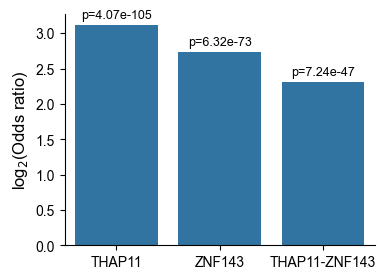

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
g = sns.barplot(data=df_stats, x="motif", y="log2OR", ax=ax)
g.set_xlabel("")
g.set_ylabel("log$_2$(Odds ratio)", fontsize=bfontsize)
g.spines[["top", "right"]].set_visible(False)
for i, (bar, p) in enumerate(zip(g.patches, df_stats["pvalue"])):
	height = bar.get_height()
	x = bar.get_x() + bar.get_width() / 2
	if p > 0.05:
		label = f"p={p:.2f}"
	else:
		label = f"p={p:.2e}"
	g.text(x, height + 0.1, label, ha="center", fontsize=sfontsize, rotation=0)

In [25]:
# Keep all these patterns 
# For each element, keep the motif with the smallest p-value

motif_positions2 = {}
for e, group in df_fimo.groupby("sequence_name"):
	top_row = group.sort_values(by="p-value").iloc[0]
	start = int(e.split("_")[1])
	mstart, mend = int(top_row["start"]), int(top_row["stop"])
	# motif center (0-based), start (0-based, included), end (0-based, not included)
	motif_positions2[e] = [start + (mstart + mend) // 2 - 1, start + mstart - 1, start + mend, top_row["strand"]]

# Get elements centered on motifs

In [26]:
mapping = {}
for g in gs:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	outputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}_{factor}.bed"
	with DelimitedWriter(outputfile) as dw:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				chrom, start, end = cols[:3]
				e = "_".join([chrom, start, end])
				if e in motif_positions2:
					center = motif_positions2[e][0]
					dw.write([chrom, center-250, center+250] + cols[3:])
					mapping[(chrom, center-250, center+250)] = e

In [27]:
# Extend to 500bp region

b = pybedtools.BedTool(f"{PROJECT_DIR_r}other/GSE266489/GSE266489_antiZNF143_ChIP2_summits.bed.gz")
chrom_sizes = f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes"
outputfile = f"{PROJECT_DIR_r}other/GSE266489/GSE266489_antiZNF143_ChIP2_summits_500bp.bed"
chroms = [f"chr{n}" for n in range(1,23)] + ["chrX"]
b.filter(lambda f: f.chrom in chroms).slop(b=250, g=chrom_sizes).saveas(outputfile)

<BedTool(/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/other/GSE266489/GSE266489_antiZNF143_ChIP2_summits_500bp.bed)>

In [28]:
# ZNF143 binding is more abundant in proximal regions

results = []
b1 = pybedtools.BedTool(f"{PROJECT_DIR_r}other/GSE266489/GSE266489_antiZNF143_ChIP2_summits_500bp.bed.gz")
es_keep = set()
for g in gs:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{g}_{factor}.bed")
	overlap = b2.intersect(b1, u=True)
	es_keep |= set(["_".join(i.fields[:3]) for i in overlap])
	results.append([f"{g.capitalize()}", len(b2), round(len(overlap)/len(b2),2)])
pd.DataFrame(results, columns=["Group", "Total No. elements with ZNF143 motifs", "Fraction of elements overlapping with ChIP-seq peaks"])

,Group,Total No. elements with ZNF143 motifs,Fraction of elements overlapping with ChIP-seq peaks
0,Divergent_distal,3037,0.25
1,Divergent_proximal,5813,0.42
2,Unidirectional_distal,1580,0.13
3,Unidirectional_proximal,617,0.17


In [29]:
for g in gs:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}_{factor}.bed"
	outputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}_{factor}_filtered.bed"
	with DelimitedWriter(outputfile) as dw:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				chrom, start, end = cols[:3]
				e = "_".join([chrom, start, end])
				if e in es_keep:
					dw.write(cols)

# Generate feature matrix

## Get individual matrix

In [10]:
# "*5pl_rpm.bw": positive values
# "*5mn_rpm.bw": negative values

bws = {f"{factor}_U_pl": f"{PROJECT_DIR_d}Alignments/{factor}_U_5pl_rpm.bw",
	   f"{factor}_U_mn": f"{PROJECT_DIR_d}Alignments/{factor}_U_5mn_rpm.bw",
	   f"{factor}_T_pl": f"{PROJECT_DIR_d}Alignments/{factor}_T_5pl_rpm.bw",
	   f"{factor}_T_mn": f"{PROJECT_DIR_d}Alignments/{factor}_T_5mn_rpm.bw",
	  }

In [30]:
df_features = {}
use_strand = True
for g in gs:
	bed = f"{PROJECT_DIR_d}bed_plot/{s}_{g}_{factor}_filtered.bed"
	all_regions = BEDXReader.read_all(GenomicCollection, bed, strandfield="f7")
	for k in ks:
		regions = list(filter(lambda a: a.stranded_genomic_pos.strand==k, all_regions))
		index = [mapping[(r.chrom, r.chromStart, r.chromEnd)] for r in regions]
		for m in bws:
			# Change the sign: maxTSS - positive values; minTSS - negative values
			if k == "+":
				sign = 1
			else:
				sign = -1
			df_features[(m,g,k)] = sign*pd.DataFrame(bpm.generate_signal_profile(regions, BigWigIReader(bws[m]), fixed_size=501, use_strand=use_strand), index=index)

In [31]:
# 10-bp bins

df_bins = {}
for k in df_features:
	df_bins[k] = utils.bin_values(df_features[k])

In [32]:
df_reformat = {}
for k in df_bins:
	df = df_bins[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

## Combine dataframes for plotting

In [33]:
df_metaplots = {}
for d, t, label in itertools.product(ds, ts, labels):
	dfs = []
	for p in ps:
		if t == "minTSS":
			df1 = pd.concat([df_reformat[(f"{factor}_U_pl", f"{p}_{d}", "-")], 
							df_reformat[(f"{factor}_U_mn", f"{p}_{d}", "+")]])
			df2 = pd.concat([df_reformat[(f"{factor}_T_pl", f"{p}_{d}", "-")], 
							df_reformat[(f"{factor}_T_mn", f"{p}_{d}", "+")]])
		else:
			df1 = pd.concat([df_reformat[(f"{factor}_U_pl", f"{p}_{d}", "+")], 
							df_reformat[(f"{factor}_U_mn", f"{p}_{d}", "-")]])
			df2 = pd.concat([df_reformat[(f"{factor}_T_pl", f"{p}_{d}", "+")], 
							df_reformat[(f"{factor}_T_mn", f"{p}_{d}", "-")]])

		filtered_df1 = df1[df1["index"].isin([k for k, v in DE_labels[t].items() if v == label])].copy()
		filtered_df1["Label"] = f"{t} (UT)"
		filtered_df2 = df2[df2["index"].isin([k for k, v in DE_labels[t].items() if v == label])].copy()
		filtered_df2["Label"] = f"{t} (T)"
		dfs.extend([filtered_df1, filtered_df2])
	df_metaplots[(d,t,label)] = pd.concat(dfs).reset_index(drop=True)	

# Generate metaplots

## Settings

In [34]:
for d, t in itertools.product(ds, ts):
	maxs = []
	mins = []
	labels2 = [f"{t} (UT)", f"{t} (T)"]
	for l1, l2 in itertools.product(labels, labels2):
		df = df_metaplots[(d,t,l1)]
		maxs.append(df[df["Label"]==l2].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==l2].groupby("Position")["Feature"].mean().min())
	print(d, t, max(maxs), min(mins))

distal minTSS 0.0 -6.883629705058411
distal maxTSS 2.5360740865580738 0.0
proximal minTSS -0.001110682687298818 -1.8947651618484245
proximal maxTSS 6.292671837321505 0.0043502743015202084


## Generate metaplots

In [35]:
def generate_metaplot(d, t, labels, df_metaplots, ylims, outputfile=None, yticks=None, xlabel="Distance (bp)", test=False):
	fig, axes = plt.subplots(1,len(labels),figsize=(5.7,1.5))
	labelpad = 2
	y_align = -0.3
	wspace = 0.3
	
	hue_order = [f"{t} (UT)", f"{t} (T)"]
	palette = ["#a6cee3", "#08519c"] if t == "minTSS" else ["#fb9a99", "#a50f15"]
	
	for label in labels:
		col = labels.index(label)
		ax = axes[col]
		df = df_metaplots[(d,t,label)]
		utils.generate_feature_metaplot(df, palette, hue_order, ax, test, "se")

		ax.spines[["right", "top"]].set_visible(False)
		ax.spines['left'].set_position(('outward', 10))
		ax.spines['bottom'].set_position(('outward', 10))

		tot = len(set(df["index"]))
		ax.set_title(f"{label} (n={tot})", fontsize=bfontsize, pad=labelpad+5)
		if col == 1:
			if t == "minTSS":
				loc = "lower right"
			else:
				loc = "upper right"
			ax.legend(loc=loc, fontsize=sfontsize)
		else:
			ax.legend([],[], frameon=False)
	
		ax.set_ylim(ylims)
		if yticks:
			ax.set_yticks(yticks)
			ax.set_yticklabels([str(y) for y in yticks])
		if col == 0:
			ax.set_ylabel("PRO-cap", fontsize=bfontsize)
			ax.yaxis.set_label_coords(y_align, 0.5)
		else:
			ax.set_ylabel("")
			ax.set_yticklabels([])
		
		xticklabel_list = ["-250", "", "", "", "", "0", "", "", "", "", "250"]
		xtick_list = [n*5 for n in range(11)]
		ax.set_xlim([0, 50])
		ax.set_xticks(xtick_list)
		ax.set_xticklabels(xticklabel_list)
		ax.set_xlabel(xlabel, fontsize=bfontsize)
		
		ax.tick_params(labelsize=sfontsize, pad=labelpad)

		ax.axhline(y=0, color="#bdbdbd", ls="--", lw="1")
		ax.axvline(x=25, ymin=-1, ymax=1, color="#bdbdbd", ls="--", lw="1", clip_on=False, zorder=1)
		
	fig.subplots_adjust(wspace=wspace)

	if outputfile:
		plt.savefig(outputfile, bbox_inches="tight", transparent=True) 

In [45]:
# The matplotlib version for other analysis is v3.9.2
# Need to change matplotlib to v3.8.3 or lower here
# Otherwise, "ax.axvline(...)" won't display as expected

In [ ]:
for d, t in itertools.product(ds, ts):
	if d == "distal":
		ylims = [-8, 0.5] if t == "minTSS" else [0, 4]
		outputfile = f"{PROJECT_DIR_o}other_figures/Fig5d.pdf" if t == "minTSS" else f"{PROJECT_DIR_o}other_figures/Fig5f.pdf"
	else:
		ylims = [-2, 0.1] if t == "minTSS" else [0, 9]
	folder = f"{PROJECT_DIR_o}figures" if d == "distal" else f"{PROJECT_DIR_o}other_figures"
	outputfile = f"{PROJECT_DIR_o}figures/Fig5d.pdf" if t == "minTSS" else f"{PROJECT_DIR_o}figures/Fig5f.pdf"
	generate_metaplot(d, t, labels, df_metaplots, ylims, outputfile)